In [474]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import kagglehub

path = kagglehub.dataset_download("shivachandel/kc-house-data")

In [476]:
import os

print(path)  # Path returned by kagglehub
print(os.listdir(path))  # Lists files in the dataset folder

/Users/poojitha/.cache/kagglehub/datasets/shivachandel/kc-house-data/versions/1
['kc_house_data.csv']


In [478]:
file_path = os.path.join(path, "kc_house_data.csv")  # Replace with actual filename
df = pd.read_csv(file_path)
df_copy=df.copy()

In [480]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503


In [482]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21611 non-null  float64
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [484]:
df['date'] = pd.to_datetime(df['date'])
df['sale_year'] = df['date'].dt.year
df['sale_month'] = df['date'].dt.month

In [486]:
df['price'].describe()

count    2.161300e+04
mean     5.400881e+05
std      3.671272e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

Skew :  4.024069144684712


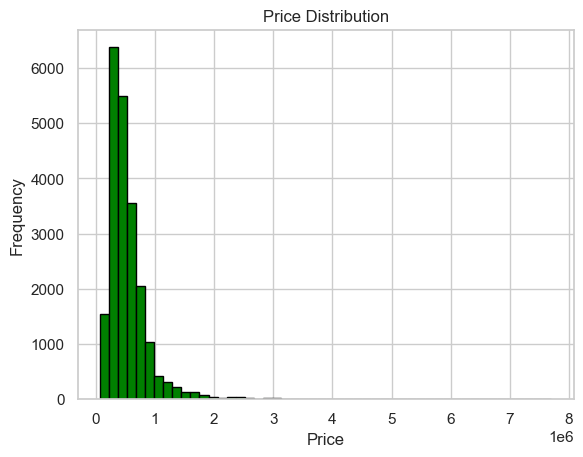

In [498]:
#Check for Skewness- Shape of distribution of target variable- price
from scipy.stats import skew
print("Skew : ",df.price.skew())
plt.hist(df.price, bins=50,color='green', ec='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution')
plt.show()

From the boxplot we can see that most of the prices is concentrated at lower price values, and there are many extreme high-price outliers. removing outliers could remove important high-value data. Skew value is >2, i.e 4.0+ which means it is extremely skewed. 
Hence we can perform a log transformation. This keeps all data, but reduces the impact of extreme outliers on linear models.

Skew :  0.42807247557592526


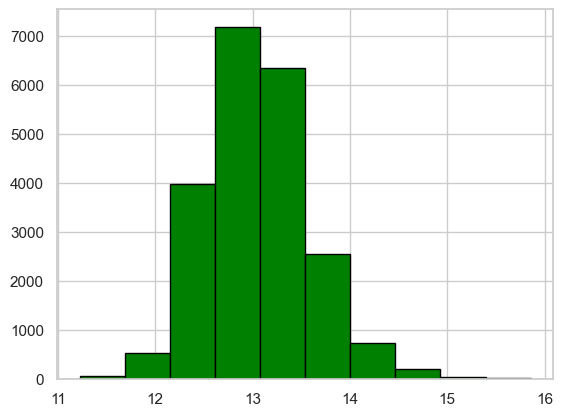

In [500]:
target = np.log(df['price'])
print("Skew : ",target.skew())
plt.hist(target, color='green', ec='black')
plt.show()


Log-transforming the target variable when it is skewed, to improve the linearity of the data

In [504]:
df.corr()['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
condition        0.036362
long             0.021626
sale_year        0.003576
date            -0.004357
sale_month      -0.010081
id              -0.016762
zipcode         -0.053203
Name: price, dtype: float64

From the corelation table we can see that sqft_living and grade are most positively corelated

Analyzing Price VS Living Area (sqft)

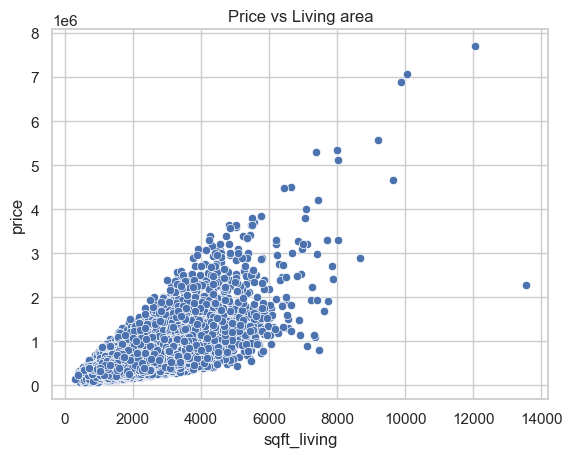

In [508]:
sns.scatterplot(data=df, x="sqft_living", y="price")

plt.title('Price vs Living area')
plt.show()

In [780]:
df['sqft_living'].describe()

count    21600.000000
mean      2080.105787
std        918.176847
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

From the dataset we know that : {sqft_living} = {sqft_above} + {sqft_basement}
If we put all three into a regression, The model will see perfect linear dependence between them.
It causes variance inflation in coefficent estimates- problem with multicollinearity.
Lets do a quick check for collinearity.

In [530]:
#Lets check if there are any Null values
df[df.isna().any(axis=1)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sale_year,sale_month
10,1736800520,2015-04-03,662500.0,3,2.5,3560,9796,1.0,0,0,...,1700,1965,0,98007,47.6007,-122.145,2210,8925,2015,4
17,6865200140,2014-05-29,485000.0,4,1.0,1600,4300,1.5,0,0,...,0,1916,0,98103,47.6648,-122.343,1610,4300,2014,5


In [532]:
mask = (df['sqft_above'].isna()) & (df['sqft_basement'] == 0)
df = df[~mask]

In [534]:
df[df.isna().any(axis=1)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sale_year,sale_month
10,1736800520,2015-04-03,662500.0,3,2.5,3560,9796,1.0,0,0,...,1700,1965,0,98007,47.6007,-122.145,2210,8925,2015,4


In [536]:
df['sqft_above'] = df['sqft_above'].fillna(df['sqft_living'] - df['sqft_basement'])

In [540]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X = df[['sqft_living', 'sqft_above', 'sqft_basement']]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


         feature  VIF
0    sqft_living  inf
1     sqft_above  inf
2  sqft_basement  inf


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


The infinite VIF values means that these variables are perfectly collinear. Lets keep the sqft_living only since
it is most correlated with price (0.702).

In [543]:
cols=['sqft_above', 'sqft_basement']
df=df.drop(cols, axis=1)

Analyzing Price Vs Grade

In [510]:
df.grade.unique()

array([ 7,  6,  8, 11,  9,  5, 10, 12,  4,  3, 13,  1])

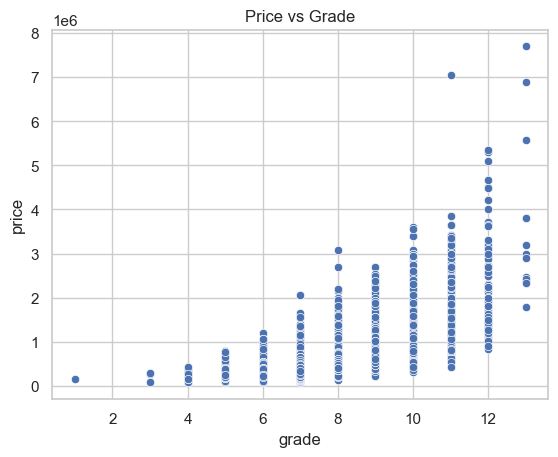

In [512]:
sns.scatterplot(x='grade', y='price' , data=df)

plt.title('Price vs Grade')
plt.show()

In [524]:
grade_pivot = df.pivot_table(index='grade', values='price' ,aggfunc='median')


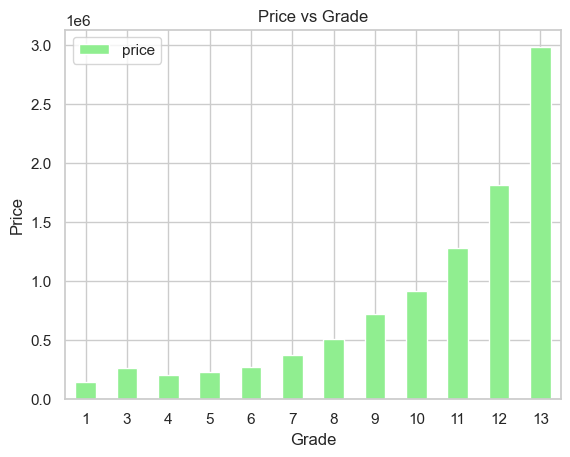

In [526]:
grade_pivot.plot(kind='bar',color='lightgreen' )
plt.xlabel('Grade')
plt.ylabel('Price')

plt.title('Price vs Grade')
plt.xticks(rotation=0)
plt.show()

Analyzing sqft_living15 - average living area of the 15 nearest neighbors

In [545]:
X = df[['sqft_living', 'sqft_living15']].dropna()

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

         feature        VIF
0    sqft_living  14.306157
1  sqft_living15  14.306157


Both have VIF ≈ 14, which is well above the usual threshold of 10. sqft_living15 is basically a neighborhood-level proxy of sqft_living.
lets keep only sqft_living since it has a stronger corelation with our target variable (0.702)
Also, sqft_living is a direct measure of the house’s size

In [551]:
cols=['sqft_living15']
df=df.drop(cols, axis=1)

Looks like there are a lot of variables are corelated. So lets run a corelation matrix heatmap

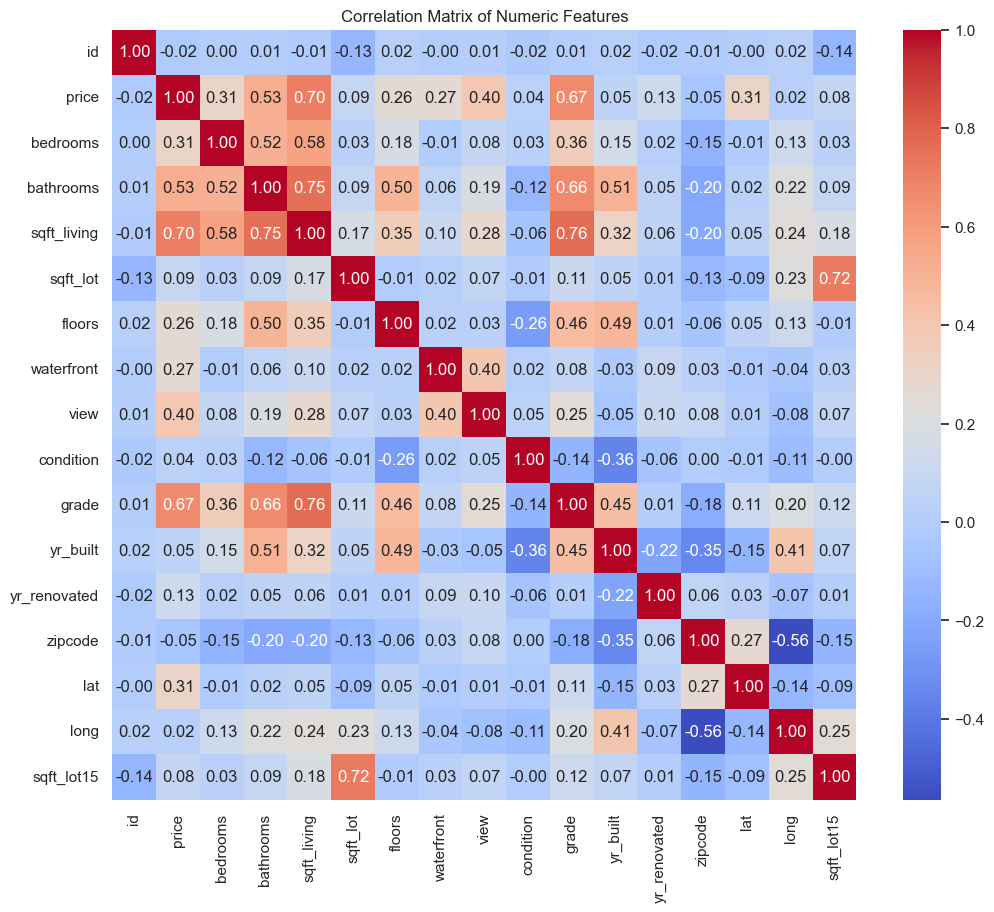

In [553]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
numeric_df = df[numeric_cols]

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix of Numeric Features")
plt.show()


In [555]:
X = df[['sqft_lot', 'sqft_lot15']].dropna()
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

      feature       VIF
0    sqft_lot  2.339265
1  sqft_lot15  2.339265


VIF ≈ 2.34 is well below the usual threshold of 5 or 10.that confirms that multicollinearity is not a problem for sqft_lot and sqft_lot15.
Can safely keep both variables in your regression model without worrying about inflated coefficients.

In [557]:
X = df[['sqft_living', 'grade']].dropna()
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

       feature       VIF
0  sqft_living  10.44793
1        grade  10.44793


looks like sqft_living and grade has VIF>10, indicating strong multicollinearity.
But grade has a strong correlation with price (0.6674). second only to sqft_living.
Keep both for now since our goal is prediction.
Lets use Ridge/Lasso regression to stabilize coefficients

In [567]:
X = df[['bathrooms', 'bedrooms']].dropna()
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

     feature        VIF
0  bathrooms  10.837533
1   bedrooms  10.837533


The VIF is high for a lot of useful variables which we might need in our modelling. lets do Ridge/lasso/Elastic net
 regression to stabilize coeffecients

Analyzing bathrooms 

In [570]:
df['bathrooms'].value_counts()

bathrooms
2.50    5380
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1446
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      72
4.75      23
5.00      21
5.25      13
0.00      10
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
6.75       2
8.00       2
6.25       2
6.50       2
7.50       1
7.75       1
Name: count, dtype: int64

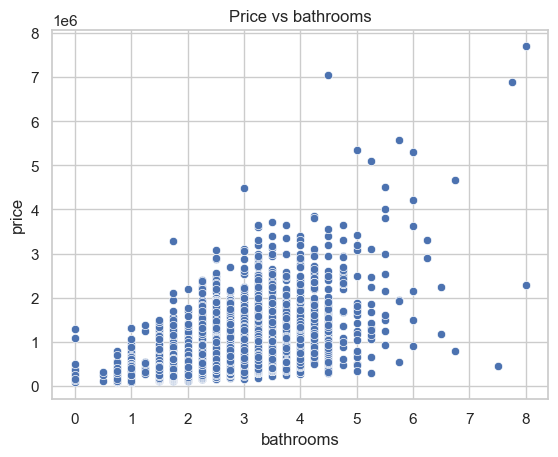

In [576]:
sns.scatterplot(data=df, x="bathrooms", y="price")

plt.title('Price vs bathrooms')
plt.show()

Analyzing View

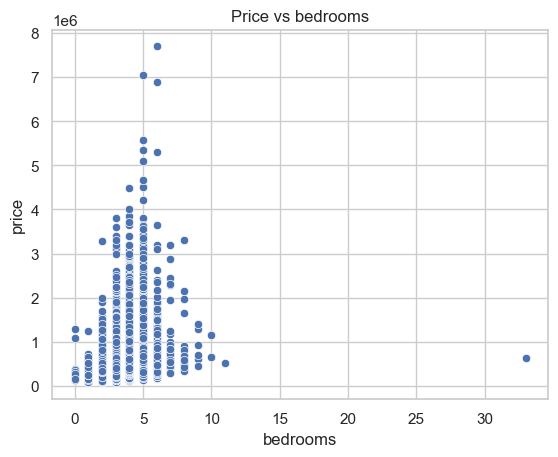

In [581]:
sns.scatterplot(data=df, x="bedrooms", y="price")

plt.title('Price vs bedrooms')
plt.show()

In [583]:
#Houses with 0 bedrooms and 0 bathrooms are very likely invalid or non-residential entries.
#Removing them is reasonable for predicting house prices
invalid_houses =df[(df['bedrooms'] == 0) & (df['bathrooms'] == 0)]

#remove invalid houses from the dataset
df = df[~((df['bedrooms'] == 0) & (df['bathrooms'] == 0))]


In [585]:
#There are just 2 houses with bedrooms >10, so we can eliminate them as it could distort our model
df = df[df['bedrooms'] <= 10]

In [587]:
df['bathrooms'].value_counts()

bathrooms
2.50    5380
1.00    3851
1.75    3047
2.25    2047
2.00    1930
1.50    1446
2.75    1185
3.00     752
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      72
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
0.00       3
6.75       2
8.00       2
6.25       2
6.50       2
7.50       1
7.75       1
Name: count, dtype: int64

In [589]:
df[df['bathrooms']==0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,yr_renovated,zipcode,lat,long,sqft_lot15,sale_year,sale_month
1149,3421079032,2015-02-17,75000.0,1,0.0,670,43377,1.0,0,0,3,3,1966,0,98022,47.2638,-121.906,42882,2015,2
5832,5702500050,2014-11-04,280000.0,1,0.0,600,24501,1.0,0,0,2,3,1950,0,98045,47.5316,-121.749,22549,2014,11
10481,203100435,2014-09-18,484000.0,1,0.0,690,23244,1.0,0,0,4,7,1948,0,98053,47.6429,-121.955,19290,2014,9


In [591]:
# Remove 1-bedroom houses with 0 bathrooms. Only 3 houses out of over 21,000 are affected. Removing them won’t significantly reduce the dataset.
#A 1-bedroom house with 0 bathrooms is likely a data entry error. 
# Including it could distort the model’s understanding of price vs. bathroom count.

df = df[~((df['bedrooms'] == 1) & (df['bathrooms'] == 0))]


In [593]:
# lets check for data rows where total land area of a house id lesser than the interior living space. These could be possible data entry errors
df[df['sqft_lot'] < df['sqft_living']]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,yr_renovated,zipcode,lat,long,sqft_lot15,sale_year,sale_month
63,9528102996,2014-12-07,549000.0,3,1.75,1540,1044,3.0,0,0,3,8,2014,0,98115,47.6765,-122.320,3090,2014,12
116,3362400431,2014-06-26,518500.0,3,3.50,1590,1102,3.0,0,0,3,8,2010,0,98103,47.6824,-122.347,3166,2014,6
175,7234600798,2015-02-10,425000.0,3,2.50,1120,1100,2.0,0,0,3,8,2008,0,98122,47.6106,-122.310,1795,2015,2
406,7821200390,2014-08-06,450000.0,3,2.00,1290,1213,3.0,0,0,3,8,2001,0,98103,47.6609,-122.344,3235,2014,8
547,7899800860,2015-03-19,259950.0,2,2.00,1070,649,2.0,0,0,3,9,2008,0,98106,47.5213,-122.357,928,2015,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21595,1972201967,2014-10-31,520000.0,2,2.25,1530,981,3.0,0,0,3,8,2006,0,98103,47.6533,-122.346,1282,2014,10
21601,5100403806,2015-04-07,467000.0,3,2.50,1425,1179,3.0,0,0,3,8,2008,0,98125,47.6963,-122.318,1253,2015,4
21604,9834201367,2015-01-26,429000.0,3,2.00,1490,1126,3.0,0,0,3,8,2014,0,98144,47.5699,-122.288,1230,2015,1
21607,2997800021,2015-02-19,475000.0,3,2.50,1310,1294,2.0,0,0,3,8,2008,0,98116,47.5773,-122.409,1265,2015,2


In [595]:
# There are about 788 houses which is a lot of data, so we can check if they are multi-story, where sqft_lot<sqft_living
invalid_lot_rows = df[df['sqft_lot'] < df['sqft_living']]

# Count frequency of floors
floor_freq = invalid_lot_rows['floors'].value_counts().sort_index()

#determining floor frequency
print(floor_freq)

floors
1.0      4
1.5      7
2.0    391
2.5     32
3.0    348
3.5      6
Name: count, dtype: int64


In [597]:
#Most have 2+ floors. very few are single story ~11 houses. So we can keep them. 
df[(df['sqft_lot'] < df['sqft_living']) & (df['floors'] < 2)]


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,yr_renovated,zipcode,lat,long,sqft_lot15,sale_year,sale_month
1549,8816400885,2014-10-08,450000.0,4,1.75,1640,1480,1.0,0,0,4,7,1912,0,98105,47.6684,-122.314,2342,2014,10
5229,9828702890,2015-02-11,760000.0,5,1.50,3050,2992,1.5,0,0,4,8,1931,0,98112,47.6210,-122.302,1209,2015,2
13253,2877104196,2014-12-06,760000.0,3,2.00,1780,1750,1.0,0,2,3,8,1927,2014,98103,47.6797,-122.357,3750,2014,12
13278,3277800845,2014-07-11,370000.0,3,1.00,1170,1105,1.0,0,0,3,7,1965,0,98126,47.5448,-122.375,1399,2014,7
13620,7011201475,2014-05-27,780000.0,3,3.00,2520,2152,1.5,0,0,3,8,1925,2006,98119,47.6363,-122.371,2152,2014,5
13874,3705000120,2014-07-29,284000.0,3,2.25,2080,2050,1.5,0,0,3,7,2003,0,98042,47.4199,-122.157,2275,2014,7
15743,9828702895,2014-10-22,700000.0,4,1.75,2420,520,1.5,0,0,3,7,1900,0,98112,47.6209,-122.302,1170,2014,10
15910,4310701330,2015-03-09,415000.0,3,1.50,1220,835,1.5,0,0,4,6,1950,0,98103,47.6981,-122.341,1251,2015,3
16931,5016002275,2014-06-02,610000.0,5,2.50,3990,3839,1.0,0,0,4,8,1962,0,98112,47.6236,-122.299,5000,2014,6
17924,8032700175,2014-10-27,420000.0,4,1.00,1510,1501,1.5,0,0,3,7,1906,0,98103,47.6526,-122.342,1602,2014,10


In [599]:
# Find the frequency of yr_renovated column
df['yr_renovated'].value_counts()


yr_renovated
0       20687
2014       91
2013       37
2003       36
2005       35
        ...  
1951        1
1959        1
1948        1
1954        1
1944        1
Name: count, Length: 70, dtype: int64

In [619]:
# Looks like majority of the houses in the dataset was never renovated.
#Only non-zero values indicate the year when a renovation took place
# lets create a binary feature- a column indicating whether a house was renovated or not

df['renovated'] = df['yr_renovated'].apply(lambda x: 0 if x==0 else 1)


KeyError: 'yr_renovated'

In [609]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21600 entries, 0 to 21612
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      21600 non-null  int64         
 1   date                    21600 non-null  datetime64[ns]
 2   price                   21600 non-null  float64       
 3   bedrooms                21600 non-null  int64         
 4   bathrooms               21600 non-null  float64       
 5   sqft_living             21600 non-null  int64         
 6   sqft_lot                21600 non-null  int64         
 7   floors                  21600 non-null  float64       
 8   waterfront              21600 non-null  int64         
 9   view                    21600 non-null  int64         
 10  condition               21600 non-null  int64         
 11  grade                   21600 non-null  int64         
 12  yr_built                21600 non-null  int64      

In [611]:
# Check unique values and frequency
df['zipcode'].value_counts()

zipcode
98103    600
98038    590
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: count, Length: 70, dtype: int64

In [613]:
# Check min and max values of lat and long values
print(df['lat'].min(), df['lat'].max())
print(df['long'].min(), df['long'].max())


47.1559 47.7776
-122.519 -121.315


In [615]:
#Dropping columns that is not needed for this regression modeling
drop_cols = [
    'id', 
    'date', 
    'yr_renovated'
]

df = df.drop(columns=drop_cols,axis=1)

In [621]:
drop_cols = ['years_since_renovation']
df = df.drop(columns=drop_cols,axis=1)

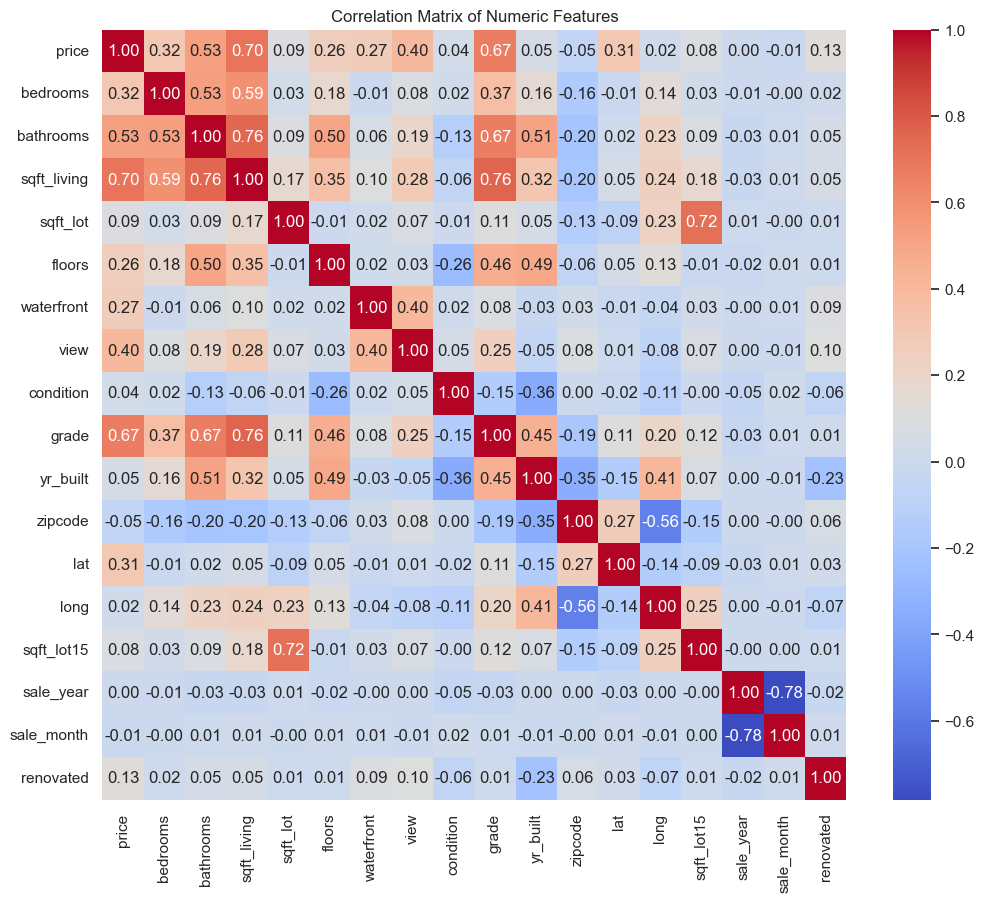

In [625]:
# Correlation check
numeric_cols = df.select_dtypes(include=['float64', 'int64','int32']).columns
numeric_df = df[numeric_cols]

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix of Numeric Features")
plt.show()


In [627]:
#to calculate mean price based on number of bedrooms, bathrooms, floors, waterfront, view, condition, grade, renovated

print(df.groupby('renovated')['price'].mean())
print(' ')
print(df.groupby('waterfront')['price'].mean())

renovated
0    530397.446464
1    760642.314348
Name: price, dtype: float64
 
waterfront
0    5.316002e+05
1    1.661876e+06
Name: price, dtype: float64


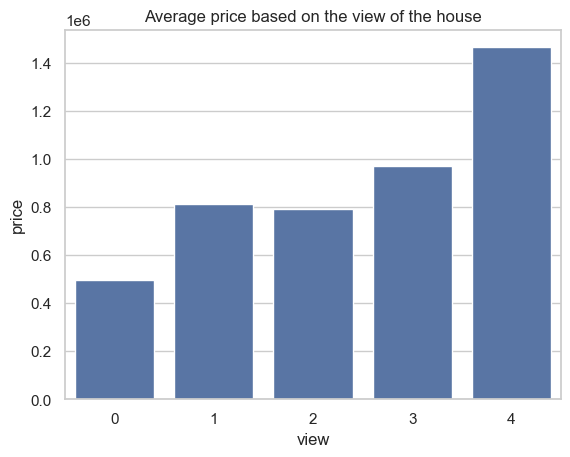

In [629]:
mean_prices = df.groupby('view')['price'].mean().reset_index()
sns.barplot(x='view', y='price', data=mean_prices)
plt.title('Average price based on the view of the house')
plt.show()


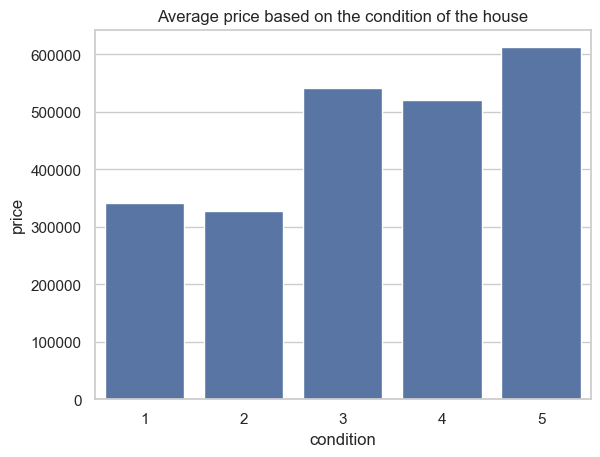

In [631]:
mean_prices = df.groupby('condition')['price'].mean().reset_index()
sns.barplot(x='condition', y='price', data=mean_prices)
plt.title('Average price based on the condition of the house')
plt.show()


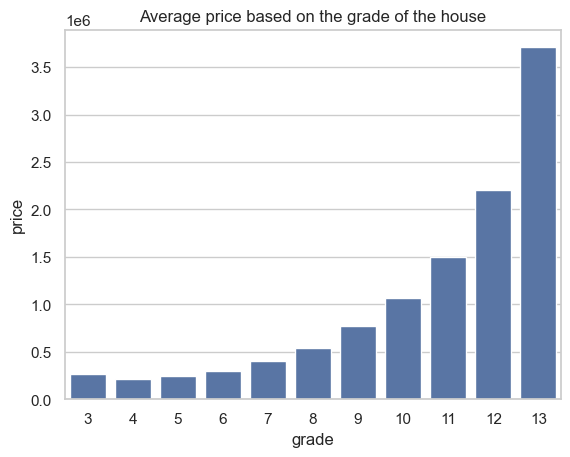

In [633]:
mean_prices = df.groupby('grade')['price'].mean().reset_index()
sns.barplot(x='grade', y='price', data=mean_prices)
plt.title('Average price based on the grade of the house')
plt.show()


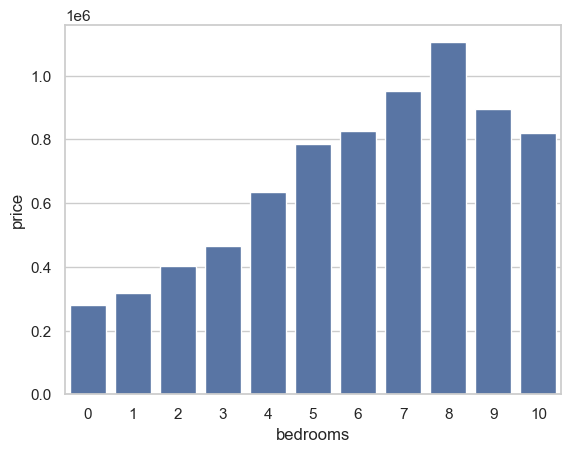

In [635]:
mean_prices = df.groupby('bedrooms')['price'].mean().reset_index()
sns.barplot(x='bedrooms', y='price', data=mean_prices)
plt.show()



In [637]:
zipcode_mean_price = df.groupby('zipcode')['price'].mean().reset_index()
zipcode_mean_price = zipcode_mean_price.sort_values(by='price', ascending=False)

# Preview
print(zipcode_mean_price.head())


    zipcode         price
24    98039  2.160607e+06
3     98004  1.355927e+06
25    98040  1.194230e+06
48    98112  1.095499e+06
41    98102  8.993954e+05


/var/folders/yz/2tvkvkzj1yjcrnwv64pv0kt00000gn/T/ipykernel_2839/1291139384.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_prices = df1.groupby('Bathroom_bin')['price'].mean().reset_index()


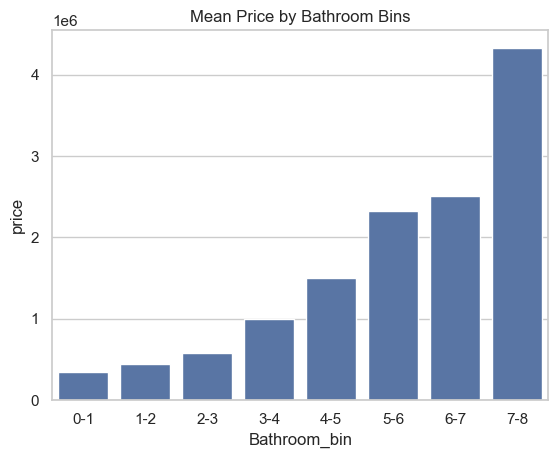

In [639]:
bins = [0, 1, 2, 3, 4, 5,6,7,8]
labels = ['0-1', '1-2', '2-3', '3-4', '4-5','5-6','6-7','7-8']
df1=df.copy()
df1['Bathroom_bin'] = pd.cut(df1['bathrooms'], bins=bins, labels=labels)

mean_prices = df1.groupby('Bathroom_bin')['price'].mean().reset_index()

sns.barplot(x='Bathroom_bin', y='price', data=mean_prices)
plt.title('Mean Price by Bathroom Bins')
plt.show()


In [298]:
df['sqft_living'].describe()

count    21601.000000
mean      2080.083561
std        918.161403
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

In [300]:
q99 = df['sqft_living'].quantile(0.99)
q995 = df['sqft_living'].quantile(0.995)

print(f"99th percentile: {q99}")
print(f"99.5th percentile: {q995}")

99th percentile: 4980.0
99.5th percentile: 5584.0


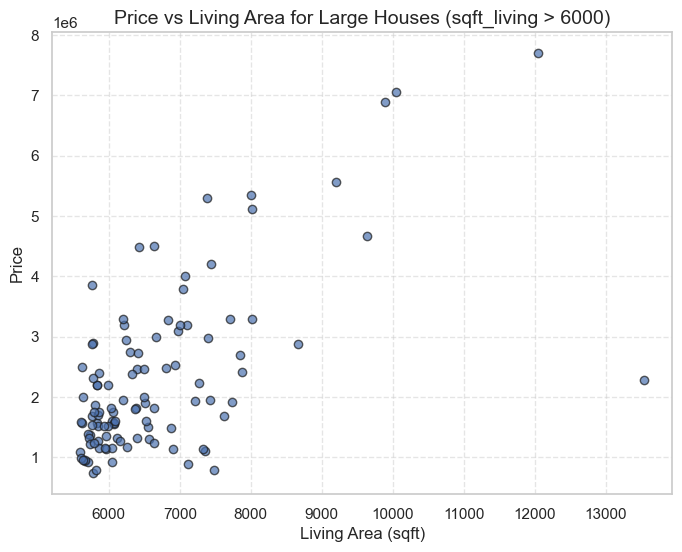

In [643]:
large_houses = df[df['sqft_living'] > q995]

# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(large_houses['sqft_living'], large_houses['price'], alpha=0.7, edgecolor='k')
plt.xlabel('Living Area (sqft)', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Price vs Living Area for Large Houses (sqft_living > 6000)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Let us keep all the data here. They could be genuine data points but rare. 

In [645]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21600 entries, 0 to 21612
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21600 non-null  float64
 1   bedrooms     21600 non-null  int64  
 2   bathrooms    21600 non-null  float64
 3   sqft_living  21600 non-null  int64  
 4   sqft_lot     21600 non-null  int64  
 5   floors       21600 non-null  float64
 6   waterfront   21600 non-null  int64  
 7   view         21600 non-null  int64  
 8   condition    21600 non-null  int64  
 9   grade        21600 non-null  int64  
 10  yr_built     21600 non-null  int64  
 11  zipcode      21600 non-null  int64  
 12  lat          21600 non-null  float64
 13  long         21600 non-null  float64
 14  sqft_lot15   21600 non-null  int64  
 15  sale_year    21600 non-null  int32  
 16  sale_month   21600 non-null  int32  
 17  renovated    21600 non-null  int64  
dtypes: float64(5), int32(2), int64(11)
memory usage: 3.

In [651]:
X = df[['zipcode', 'long','lat']]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

   feature           VIF
0  zipcode  1.226396e+06
1     long  1.092997e+06
2      lat  1.260072e+05


This confirms severe multicollinearity among these three location features.

In [653]:
df = df.drop(columns=['lat', 'long'])


In [655]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21600 entries, 0 to 21612
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21600 non-null  float64
 1   bedrooms     21600 non-null  int64  
 2   bathrooms    21600 non-null  float64
 3   sqft_living  21600 non-null  int64  
 4   sqft_lot     21600 non-null  int64  
 5   floors       21600 non-null  float64
 6   waterfront   21600 non-null  int64  
 7   view         21600 non-null  int64  
 8   condition    21600 non-null  int64  
 9   grade        21600 non-null  int64  
 10  yr_built     21600 non-null  int64  
 11  zipcode      21600 non-null  int64  
 12  sqft_lot15   21600 non-null  int64  
 13  sale_year    21600 non-null  int32  
 14  sale_month   21600 non-null  int32  
 15  renovated    21600 non-null  int64  
dtypes: float64(3), int32(2), int64(11)
memory usage: 2.6 MB


In [657]:
df['house_age'] = 2025 - df['yr_built']
df['years_since_sale'] = 2025 - df['sale_year']
df = df.drop(columns=['sale_year', 'yr_built'])

In [659]:
df2=df.copy()

In [663]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21600 entries, 0 to 21612
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             21600 non-null  float64
 1   bedrooms          21600 non-null  int64  
 2   bathrooms         21600 non-null  float64
 3   sqft_living       21600 non-null  int64  
 4   sqft_lot          21600 non-null  int64  
 5   floors            21600 non-null  float64
 6   waterfront        21600 non-null  int64  
 7   view              21600 non-null  int64  
 8   condition         21600 non-null  int64  
 9   grade             21600 non-null  int64  
 10  zipcode           21600 non-null  int64  
 11  sqft_lot15        21600 non-null  int64  
 12  sale_month        21600 non-null  int32  
 13  renovated         21600 non-null  int64  
 14  house_age         21600 non-null  int64  
 15  years_since_sale  21600 non-null  int32  
dtypes: float64(3), int32(2), int64(11)
memory usa

In [671]:
# Convert nominal categorical variables to string
df['zipcode'] = df['zipcode'].astype(str)
df = pd.get_dummies(df, columns=['zipcode'], drop_first=True, dtype=int)


In [673]:
X = df.drop(columns=['price'])

# Set y variable
y = np.log(df.price)

# Display first few rows
X.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_lot15,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,3,1.00,1180,5650,1.0,0,0,3,7,5650,...,0,0,0,0,0,0,1,0,0,0
1,3,2.25,2570,7242,2.0,0,0,3,7,7639,...,0,0,0,0,0,0,0,0,0,0
2,2,1.00,770,10000,1.0,0,0,3,6,8062,...,0,0,0,0,0,0,0,0,0,0
3,4,3.00,1960,5000,1.0,0,0,5,7,5000,...,0,0,0,0,0,0,0,0,0,0
4,3,2.00,1680,8080,1.0,0,0,3,8,7503,...,0,0,0,0,0,0,0,0,0,0


In [675]:
# Packages for date conversions for calculating trip durations
from datetime import datetime
from datetime import date
from datetime import timedelta

# Packages for OLS, MLR, confusion matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics # For confusion matrix

# Create training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [677]:
# Standardize the X variables
scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
print('X_train scaled:', X_train_scaled)

X_train scaled: [[ 0.69618802  0.49458225  0.51414321 ... -0.08220907 -0.1138202
  -0.12311318]
 [-0.40789871  0.17199208 -0.28404036 ... -0.08220907 -0.1138202
  -0.12311318]
 [-0.40789871  0.17199208 -0.46740685 ... -0.08220907 -0.1138202
  -0.12311318]
 ...
 [-1.51198543 -0.15059808 -0.76942225 ... -0.08220907 -0.1138202
  -0.12311318]
 [-0.40789871 -0.47318825 -0.74784972 ... -0.08220907 -0.1138202
  -0.12311318]
 [ 0.69618802  0.81717241  0.67593718 ... -0.08220907 -0.1138202
  -0.12311318]]


In [683]:
X_test_scaled=scaler.transform(X_test)

In [685]:
X_train_scaled.shape, X_test_scaled.shape

((17280, 83), (4320, 83))

MODEL BUILDING:
Ridge regression

In [687]:
from sklearn.linear_model import Ridge 

ridge_reg = Ridge(alpha=100)
ridge_reg.fit(X_train_scaled ,y_train) 

y_pred_ridge =ridge_reg.predict(X_test_scaled)

In [689]:
#Testing the model
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

print("Mean Absolute Error : " ,mean_absolute_error(y_test ,y_pred_ridge))
print("R2 score :" ,r2_score(y_test ,y_pred_ridge))

Mean Absolute Error :  0.1369595173890955
R2 score : 0.868862605929912


In [691]:
# finding best value for alpha and train model again

from sklearn.model_selection import GridSearchCV
params = {'alpha': np.arange(0.01, 200, 0.5)}
ridge = Ridge()
grid = GridSearchCV(ridge, params, scoring='neg_mean_absolute_error', cv=5)
grid.fit(X_train_scaled, y_train)

print("Best alpha:", grid.best_params_['alpha'])
print("Best CV MAE:", -grid.best_score_)

Best alpha: 0.01
Best CV MAE: 0.1390827751326275


In [697]:
#Retrain Ridge on the full training data with alpha=0.01 and evaluate on the test set:

ridge_final = Ridge(alpha=0.01)
ridge_final.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_final.predict(X_test_scaled)

print("Test MAE:", mean_absolute_error(y_test, y_pred_ridge))
print("Test R²:", r2_score(y_test, y_pred_ridge))


Test MAE: 0.13649406589812135
Test R²: 0.870049604959136


R² is slightly higher (0.87 compared to 0.8688). MAE is slightly lower (0.1364940 compared to 0.13695) with alpha = 0.01 → better generalization.
The difference is small, so model is stable — a good sign that it’s not overly sensitive to the regularization strength.

In [699]:
y_pred_ridge.min()

11.905316317558187

<Axes: ylabel='price'>

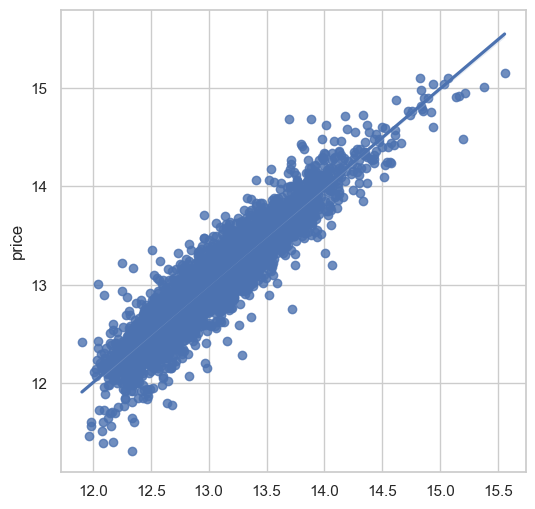

In [709]:
plt.figure(figsize=(6,6))
sns.regplot(x=y_pred_ridge ,y=y_test)

Lasso Regression

In [711]:
from sklearn.linear_model import Lasso 
lasso = Lasso(alpha=0.8)

In [713]:
lasso.fit(X_train_scaled ,y_train)
y_pred_lasso = lasso.predict(X_test_scaled)

In [715]:
print("Mean Absolute Error : ", mean_absolute_error(y_test, y_pred_lasso))
print("R2 score :", r2_score(y_test, y_pred_lasso))

Mean Absolute Error :  0.4064693080819897
R2 score : -0.0002504168054737743


In [717]:
# finding best value for alpha and train model again
# MAE ~ 0.406 is way worse than Ridge (~0.136). R² ~ 0.0 means Lasso is basically performing no better than just predicting the mean of y
# this is because alpha is too large causing Lasso to shrink almost all coefficents to 0. Extremem underfitting alpha=0.8
# Ridge model optimal alpha was 0.01, already small.
#Lasso is more sensitive to large alphas than Ridge. Alphs=0.8 suggests that it is an over regularized one. 
#So sweet spot of alpha is very close to 0. hence lets provide a range as (0.0001, 1, 0.001) 

params = {'alpha': np.arange(0.0001, 1, 0.001)}
lasso = Lasso(max_iter=10000)
grid = GridSearchCV(ridge, params, scoring='neg_mean_absolute_error', cv=5)
grid.fit(X_train_scaled, y_train)

print("Best alpha:", grid.best_params_['alpha'])
print("Best CV MAE:", -grid.best_score_)

Best alpha: 0.0001
Best CV MAE: 0.139082767288254


In [719]:
# training and testing once again with the best alpha value

lasso = Lasso(alpha=0.0001)
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)

In [721]:
# testing the model

print("Mean Absolute Error : ", mean_absolute_error(y_test, y_pred_lasso))
print("R2 score :", r2_score(y_test, y_pred_lasso))

Mean Absolute Error :  0.13655292448514955
R2 score : 0.8698482759493307


test performance of Lasso at alpha = 0.0001 is almost identical to Ridge.
Lasso’s tiny alpha means it isn’t really doing any feature selection — all coefficients are mostly retained.
Ridge (alpha = 0.01) and Lasso (alpha = 0.0001) give very similar results, but Ridge is simpler to interpret here.

In [723]:
y_pred_lasso.min()

11.904305715517605

<Axes: ylabel='price'>

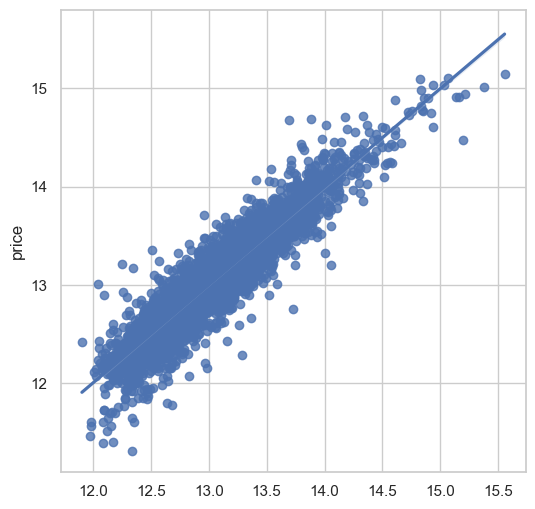

In [725]:
plt.figure(figsize=(6, 6))
sns.regplot(x=y_pred_lasso, y=y_test)

Elastic Net

In [728]:
from sklearn.preprocessing import PolynomialFeatures 
polynomial_converter = PolynomialFeatures(degree=2, include_bias=False)

In [741]:
poly_features_train = polynomial_converter.fit_transform(X_train_scaled)
poly_features_test = polynomial_converter.transform(X_test_scaled)

In [743]:
from sklearn.linear_model import ElasticNetCV 

elastic = ElasticNetCV(l1_ratio= 1,tol=0.01)
elastic.fit(poly_features_train , y_train)
y_pred_elastic = elastic.predict(poly_features_test)

In [744]:
#testing model

print("Mean Absolute Error : ", mean_absolute_error(y_test, y_pred_elastic))
print("R2 score :", r2_score(y_test, y_pred_elastic))

Mean Absolute Error :  0.1268550952302263
R2 score : 0.8847068081648208


In [753]:
#to find optimal l1_ratio values. l1_ratio = 0 -> Ridge, 1 -> Lasso, values in between -> ElasticNet

l1_ratios = np.linspace(0.01, 1, 20)


elastic_cv = ElasticNetCV(
    l1_ratio=l1_ratios,   # will search over these
    alphas=None,          # will pick automatically
    cv=5,                 # 5-fold CV
    max_iter=10000,
   random_state=42
)

# Fit on training data (scaled if needed)
elastic_cv.fit(poly_features_train, y_train)

# Make predictions
y_pred_elastic = elastic_cv.predict(poly_features_test)

# Best hyperparameters
print("Best alpha:", elastic_cv.alpha_)
print("Best l1_ratio:", elastic_cv.l1_ratio_)

# Performance metrics
print("Test MAE:", mean_absolute_error(y_test, y_pred_elastic))
print("Test R²:", r2_score(y_test, y_pred_elastic))

Best alpha: 0.008544088551345329
Best l1_ratio: 0.16631578947368422
Test MAE: 0.12676261557208673
Test R²: 0.8848211449852819


The CV-tuned ElasticNet is slightly better: lower MAE and higher R² (even if the differences are tiny)
This indicates that a mix of Ridge and Lasso (l1_ratio ≈ 0.166) generalizes slightly better than pure Lasso (l1_ratio = 1) on the dataset.

Earlier we saw that sqft_living, grade, bathrooms were highly correlated. if we choose l1_ratio=1, which means lasso only- 
the model arbitrarily pick one of the correlated variables and zero out the others.This can slightly reduce predictive stability even if MAE looks good on one split
ElasticNet with l1_ratio ≈ 0.166:Mostly Ridge → stabilizes coefficients of correlated features.
Small Lasso component → still allows minor sparsity.
Result: slightly better MAE and R², because the model handles multicollinearity more gracefully.

On datasets with correlated numeric features, ElasticNet with l1_ratio closer to Ridge (small L1 component) often outperforms pure Lasso.
Only use l1_ratio=1 (pure Lasso) if you want strong feature selection and are okay with potential instability in correlated predictors.

In [760]:
y_pred_elastic.min()

11.843272514017128

<Axes: ylabel='price'>

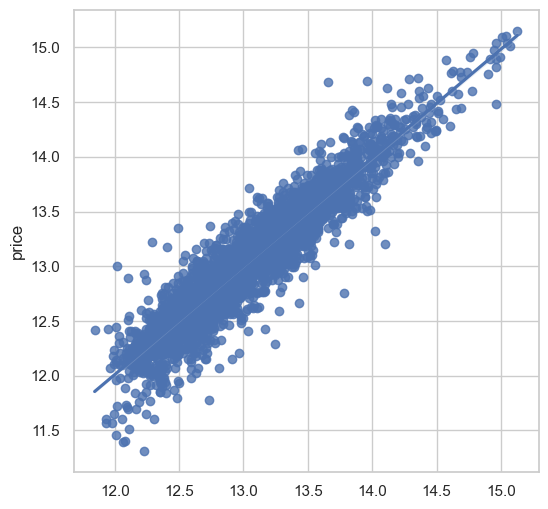

In [762]:
plt.figure(figsize=(6, 6))
sns.regplot(x=y_pred_elastic, y=y_test)

MODEL EVALUATION

In [768]:
# creating Dataframe to check which regression technique was the best 

models = {
    "Ridge": y_pred_ridge,
    "Lasso": y_pred_lasso,
    "ElasticNet": y_pred_elastic}

metrics=[]

for name,y_pred in models.items():
    mae=mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    metrics.append({
        "Regression Model": name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    })

metrics_df = pd.DataFrame(metrics)
metrics_df = metrics_df.sort_values(by="MAE", ascending=True)
print(metrics_df)

  Regression Model       MAE       MSE      RMSE        R²
2       ElasticNet  0.126763  0.030554  0.174796  0.884821
0            Ridge  0.136494  0.034472  0.185666  0.870050
1            Lasso  0.136553  0.034525  0.185810  0.869848


In [778]:
# Lets take ElasticNet model as the best fit model in this case, and determine its coefficients
feature_names = polynomial_converter.get_feature_names_out(X_train.columns)

# Get coefficients from the trained model
coefficients = elastic_cv.coef_

# Combine feature names and coefficients into a DataFrame
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
})

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)
print(coef_df.head(20))

                    Feature  Coefficient
2               sqft_living     0.202497
8                     grade     0.124224
3                  sqft_lot     0.047500
6                      view     0.033274
13         years_since_sale    -0.033147
7                 condition     0.029399
1                 bathrooms     0.025560
3338        zipcode_98115^2     0.020677
3163        zipcode_98103^2     0.020403
3379        zipcode_98117^2     0.018920
1291        zipcode_98004^2     0.016561
85     bedrooms sqft_living    -0.016459
2666        zipcode_98052^2     0.015923
258   sqft_living house_age    -0.014970
2344        zipcode_98033^2     0.013875
1013            house_age^2     0.013705
1424        zipcode_98006^2     0.013532
2393        zipcode_98034^2     0.012319
9                sqft_lot15     0.012295
87          bedrooms floors     0.012040


The coefficients reveal that sqft_living was the feature with the greatest weight in the model's final prediction. 
Here is how it can be interpreted:
sqft_living has a coefficient of 0.202497. Since these values are scaled, "one-unit” change here does not mean 1 square foot, but 1 standard deviation of sqft_living. 
From our dataset, std_dev of sqft_living is 918. So, an increase of 918 sq ft (1 std) in sqft_living increases the predicted price by approximately 0.202497 standard deviations of price. Std_dev of price is 367,127. So in dollar terms:
Impact on price≈ 0.202497×367,127=$74,400

1. A 1 standard deviation increase in sqft_living (~918 sq ft) is associated with an increase of ~$74k in house price, holding other features constant.
2. Holding all other variables constant, for every 1 unit increase in grade, the predicted scaled target (price) increases by 0.124224 units~ the predicted house price increases by roughly $45,600
3. For years_since_sale the coeff is -0.033; A 1 SD increase in years_since_sale ≈ 0.4676 years, so going from 10 → 11 years is ~2.14 SDs( there are only 2 values 10,11 in this dataset). Homes sold 1 year later (from 10 → 11 years since sale) are predicted to be about $26k cheaper, all else being equal.
4. For a 1 SD increase in bathrooms (~0.769 bathrooms), the price increases by about: 0.025560 ×367,127≈$9,381.If a house has one extra full bathroom (roughly 1 unit increase), it increases price by ~0.025560 × (367,127 ÷ 0.769) ≈ $12,200 . Fractional bathrooms (like 0.5 increase) scale proportionally (~$6,100 for half a bathroom).
5. Being in zipcode 98115 is associated with a small increase in price (~$7.6k), holding all else constant. even though the coeffecient -zipcode_98115^2 is polynomial, it is a one-hot encoded variable. So, Polynomial features like ^2 on binary one-hot columns are usually redundant.
6. bedrooms sqft_living is a polynomial (interaction) feature created from bedrooms × sqft_living. this variabe captures the combined effects of bedrooms and sqft_living. here since the coefficent value is -0.016, A 1 SD increase in the interaction term → 0.016459 SD decrease in price. The negative coefficient suggests that, holding other factors constant, having higher combinations of bedrooms and living area slightly reduces price, which might seem counterintuitive. Often, this happens due to multicollinearity in polynomial features: interactions can have coefficients with signs that are hard to interpret directly.
7. sqft_living house_age- Large homes that are older slightly decrease price; captures interplay between age & size . For every 1 SD increase of sqft_living house_age, price deceases by $5501